# Estimate foreground mask in 2D image

# Setup environment

In [40]:
%matplotlib inline

import numpy as np
import glob

from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [42]:
from importlib import reload

import utils
reload(utils)
from utils import *

import unet
reload(unet)
from unet import generate_model

# Parameter setting

In [43]:
matrix_size = (320, 400)
num_classes = 2
num_channel = 3

model_filename = 'models/weights.h5'
monitor = 'val_loss'
nb_epoch = 50
validation_split = 0.1

In [44]:
!ls

datasets  FGSeg.ipynb  models  __pycache__  README.md  tmp  unet.py  utils.py


## Load data

In [45]:
imgs_resized = []
masks_resized = []

count_case = 0
for fn_img in glob.glob('datasets/img*.jpg'):
    img_ID = get_img_ID(fn_img)
    fn_mask = 'datasets/mask' + img_ID + '.jpg'
    
    # Load image
    img = load_data(fn_img)
    
    # Resize image
    img_resized = resize(img, matrix_size)
    #print(img_resized.shape)
    
    # Load mask
    mask = load_data(fn_mask, flag_mask=True)
    
    # Resize mask
    mask_resized = resize(mask[np.newaxis,:], matrix_size)[0,:,:]

    
    imgs_resized.append(img_resized)
    masks_resized.append(mask_resized)
    
    count_case += 1
    if count_case%100 == 0:
        print('Loaded {} cases'.format(count_case))
    
imgs_resized = np.stack(imgs_resized, axis=0)
masks_resized = np.stack(masks_resized, axis=0)

Loaded 100 cases
Loaded 200 cases


In [46]:
# Convert mask to one-hot label
labels_resized = np_utils.to_categorical(masks_resized, num_classes)
del masks_resized

In [47]:
print(imgs_resized.shape, labels_resized.shape)

(292, 3, 320, 400) (292, 320, 400, 2)


In [48]:
data_train, data_test, label_train, label_test = train_test_split(imgs_resized, labels_resized, test_size = 0.1)

In [49]:
print(data_train.shape, data_test.shape, label_train.shape, label_test.shape)

(262, 3, 320, 400) (30, 3, 320, 400) (262, 320, 400, 2) (30, 320, 400, 2)


(None, None)

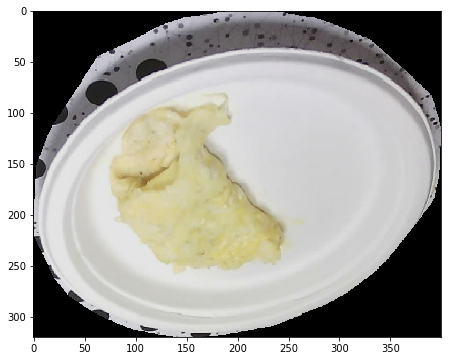

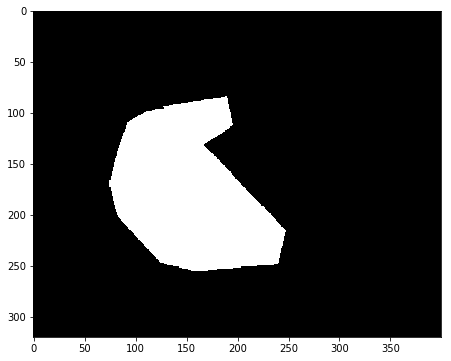

In [50]:
plots(data_test[18,:,:,:]), plots(label_test[18,:,:,1], scale=(0,1))

## Create model (U-Net) 

In [10]:
# Build model
model = generate_model(num_classes, num_channel, input_size=matrix_size, output_size=matrix_size)

In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 320, 400)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 320, 400) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu_1 (PReLU)               (None, 64, 320, 400) 8192000     conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 320, 400) 256         p_re_lu_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

## Configure callback

In [12]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename,
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

callbacks = [checkpointer]

## Start training 

Train on 235 samples, validate on 27 samples
Epoch 1/50
235/235 [==============================] - 29s 123ms/step - loss: 0.0754 - categorical_accuracy: 0.9724 - val_loss: 0.1315 - val_categorical_accuracy: 0.9447
Epoch 2/50
235/235 [==============================] - 27s 114ms/step - loss: 0.0762 - categorical_accuracy: 0.9724 - val_loss: 0.0871 - val_categorical_accuracy: 0.9749
Epoch 3/50
235/235 [==============================] - 27s 114ms/step - loss: 0.0732 - categorical_accuracy: 0.9742 - val_loss: 0.0637 - val_categorical_accuracy: 0.9773
Epoch 4/50
235/235 [==============================] - 27s 114ms/step - loss: 0.0789 - categorical_accuracy: 0.9720 - val_loss: 0.0748 - val_categorical_accuracy: 0.9767
Epoch 5/50
235/235 [==============================] - 27s 114ms/step - loss: 0.0734 - categorical_accuracy: 0.9742 - val_loss: 0.0644 - val_categorical_accuracy: 0.9782
Epoch 6/50
235/235 [==============================] - 27s 114ms/step - loss: 0.0685 - categorical_accuracy: 0.

Epoch 49/50
235/235 [==============================] - 29s 122ms/step - loss: 0.0302 - categorical_accuracy: 0.9874 - val_loss: 0.0475 - val_categorical_accuracy: 0.9827
Epoch 50/50
235/235 [==============================] - 29s 123ms/step - loss: 0.0294 - categorical_accuracy: 0.9877 - val_loss: 0.0686 - val_categorical_accuracy: 0.9752


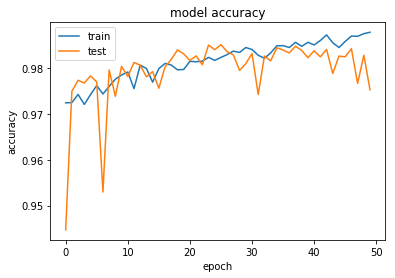

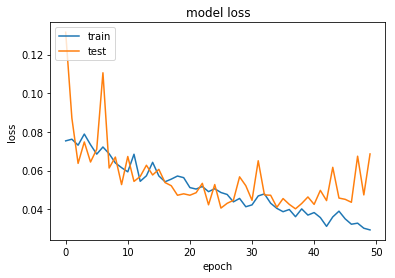

In [19]:
K.set_value(model.optimizer.lr, 1e-4)

history = model.fit(
    data_train,
    label_train,
    batch_size=5,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train
#del aux_train

# summarize history for accuracy
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Load optimal model

In [51]:
model = generate_model(num_classes, num_channel, input_size=matrix_size, output_size=matrix_size)

model.load_weights('models/weights_optimal.h5')

## Apply to test data

In [52]:
infers_test = []

for img_test in data_test:
    
    pred = model.predict(img_test[np.newaxis,:], verbose=1)
    pred_classes = np.argmax(pred, axis=-1)
    
    mask_test = pred_classes

    infers_test.append(mask_test)

infers_test = np.stack(infers_test, axis=0)

1/1 [==============================] - 0s 51ms/step


In [53]:
infers_test.shape, label_test.shape

((30, 1, 320, 400), (30, 320, 400, 2))

(None, None, None)

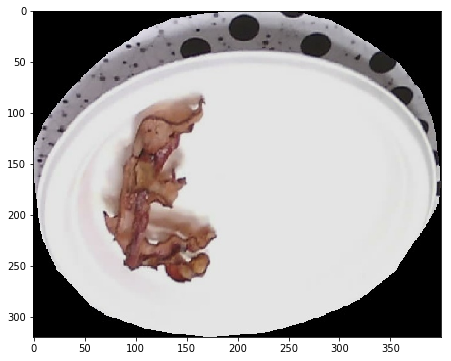

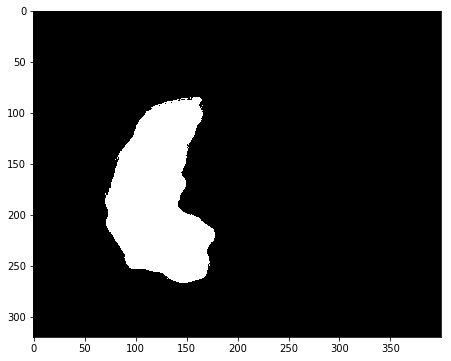

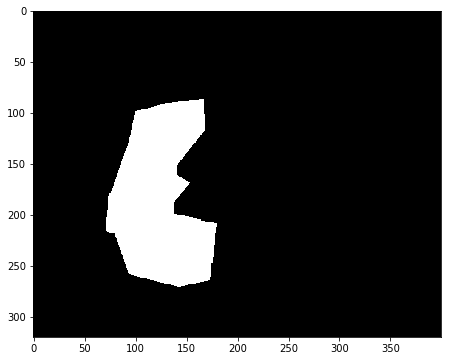

In [54]:
plots(data_test[11,:,:,:]), plots(infers_test[11,0,:,:], scale = (0, 1)), plots(label_test[11,:,:,1], scale = (0, 1))

## Calculate metric (Dice)

In [55]:
for i in range(len(data_test)):
    mask_pred = infers_test[i,0,:,:]
    mask_true = label_test[i,:,:,1]
    
    dice = calc_dice(mask_pred, mask_true)
    print(i, dice)

0 0.9703814378198988
1 0.9641769725037744
2 0.9409382103351545
3 0.9769358075644587
4 0.9620965723992339
5 0.9630492837599879
6 0.977868004126823
7 0.967135527225603
8 0.9795334040167083
9 0.9757092321429465
10 0.959949856248299
11 0.9333073474592357
12 0.9728365680322343
13 0.9708005185671007
14 0.9819059107164091
15 0.9757776128246907
16 0.9664301908635893
17 0.965039281678871
18 0.9487280874931138
19 0.9801936341097662
20 0.9697443593728199
21 0.9770942674442188
22 0.9657576753008842
23 0.9747496881472753
24 0.9691745923775876
25 0.9637280129379348
26 0.9707795870600808
27 0.9744414876856723
28 0.9758136476623646
29 0.970299433164982


## Save segmented mask 

In [57]:
save_data(mask_true, 'tmp/tst.jpg', flag_mask=True)
